# Import Packages

In [64]:
import pickle
import os
from datetime import datetime, timedelta
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import eli5
import shap
import matplotlib as mpl
import matplotlib.dates as mdates
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

# TEMPORARY MANUAL INPUT STEP

In [65]:
data = {
    'DATE': ['2023-07-24'],
    'MAX TEMPERATURE': ['83'],
    'AVG WIND': [4],
    'TOTAL PRECIPITATION': [0.55]
}

# Create the DataFrame
yesterday_weather= pd.DataFrame(data)
yesterday_weather['MAX TEMPERATURE'] = pd.to_numeric(yesterday_weather['MAX TEMPERATURE'])
yesterday_weather

,DATE,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION
0,2023-07-24,83,4,0.55


# Read in Cora Data, Process

In [66]:
noaa_id = 'NOAA_3392043'
lookback_days_list = [2, 3, 7]


In [67]:
df = pd.read_csv('cora-history-raw.csv')
df['date_clean'] = df['date'].str[:10]
df["date_clean"] = pd.to_datetime(df["date_clean"])
data = df.copy().sort_values(by="date", ascending=False)
data.head(1)

,trail,date,status,date_clean
628,East Fork State Park,2023-03-22 9:30:05,closed,2023-03-22


In [68]:
# Take the latest update in the day to classify the whole day
# Each day trails will often have multiple updates, open the day as open but then it rains, so it closes
# something to keep in mind when building the methodology
data_grouped = data.groupby("date_clean", as_index=False).first()
data_grouped = data_grouped.sort_values(by="date_clean", ascending=True)

In [69]:
# Create a new dataframe with all possible dates
all_dates = pd.date_range(start=data['date_clean'].min(), end=data['date_clean'].max(), freq='D')
all_dates_df = pd.DataFrame({'date_clean': all_dates})
all_dates_df.head(1)

,date_clean
0,2019-11-27


In [70]:
# Create a new dataframe with all possible dates and trails
all_dates = pd.date_range(start=data['date_clean'].min(), end=data['date_clean'].max(), freq='D')
all_trails = data['trail'].unique()
all_dates_df = pd.DataFrame({
    'date_clean': pd.date_range(start=data['date_clean'].min(), end=data['date_clean'].max(), freq='D').repeat(len(all_trails)),
    'trail': list(all_trails) * len(all_dates)
})

all_dates_df['date_clean'] = pd.to_datetime(all_dates_df['date_clean'])
data = data.sort_values('date_clean')

# Merge the two dataframes, filling in missing values with the latest status available
merged_df = pd.merge_asof(all_dates_df, data, on='date_clean', by='trail', direction='backward')

# Forward fill the 'status' column to fill in any missing values
merged_df['status'] = merged_df['status'].fillna(method='ffill')

# Remove any unnecessary columns and sort by date_clean
trail_df = merged_df[['date_clean', 'trail', 'status']].sort_values('date_clean')

trail_df.sort_values(['trail','date_clean']).head(5)

,date_clean,trail,status
4,2019-11-27,Caesar Creek,closed
16,2019-11-28,Caesar Creek,closed
28,2019-11-29,Caesar Creek,caution
40,2019-11-30,Caesar Creek,caution
52,2019-12-01,Caesar Creek,caution


# Load in NOAA Weather Data, Process

In [71]:
weather_df = pd.read_csv(noaa_id + '.csv')
print(weather_df['DATE'].min())
print(weather_df['DATE'].max())

2020-01-01
2023-07-11


## Some Stations have more missing data than others
- Not sure why this is, data is just corrupted and/or missing certain days at some stations

In [72]:
# Subset the DataFrame to include only the relevant columns
cols = ['NAME', 'AWND', 'PRCP', 'SNOW', 'TMAX', 'DATE']
df_subset = weather_df[cols]

# Get the max date from the DataFrame
max_date = df_subset['DATE'].max()

# Filter the DataFrame to only include rows with the max date
df_max_date = df_subset[df_subset['DATE'] == max_date]

# Group the DataFrame by the categorical column and count the missing values
grouped = df_max_date.groupby('NAME')
missing_counts = grouped.apply(lambda x: x.isnull().sum())

# Find the group with the least missing values
min_missing_index = missing_counts.sum(axis=1).idxmin()

# Retrieve the DataFrame for the group with the least missing values
df_min_missing = grouped.get_group(min_missing_index)
df_min_missing['NAME'].unique()


weather_df_clean = weather_df[weather_df['NAME'] == min_missing_index]

weather_df_clean = weather_df_clean[['DATE', 'STATION', 'NAME', 'AWND', 'PRCP','SNOW','TAVG',
                                     'TMAX','TMIN']]

weather_df_clean.head(1)


,DATE,STATION,NAME,AWND,PRCP,SNOW,TAVG,TMAX,TMIN
10814,2020-01-01,USW00093814,CINCINNATI NORTHERN KENTUCKY INTERNATIONAL AIR...,9.84,0.0,0.0,38.0,48.0,34.0


In [73]:
# Subset the DataFrame to include only the relevant columns
cols = ['NAME', 'AWND']
df_subset = weather_df[cols]

# Group the DataFrame by the categorical column and count the missing values
grouped = df_subset.groupby('NAME')
missing_counts = grouped.apply(lambda x: x.isnull().sum())

# Find the group with the least missing values
min_missing_index = missing_counts.sum(axis=1).idxmin()

# Retrieve the DataFrame for the group with the least missing values
df_min_missing = grouped.get_group(min_missing_index)
df_min_missing['NAME'].unique()

# weather_df['NAME'].unique()

weather_df_clean = weather_df[weather_df['NAME'] == 'CINCINNATI NORTHERN KENTUCKY INTERNATIONAL AIRPORT, KY US']

weather_df_clean = weather_df_clean[['DATE', 'STATION', 'NAME', 'AWND', 'PRCP','SNOW','TAVG',
                                     'TMAX','TMIN']]

weather_df_clean.head(1)

,DATE,STATION,NAME,AWND,PRCP,SNOW,TAVG,TMAX,TMIN
10814,2020-01-01,USW00093814,CINCINNATI NORTHERN KENTUCKY INTERNATIONAL AIR...,9.84,0.0,0.0,38.0,48.0,34.0


## Check for Missing Values

In [74]:
# Count the number of missing values in each column
missing_value_counts = weather_df_clean.isnull().sum()

# Print the number of missing values in each column
print(missing_value_counts[missing_value_counts > 0])

Series([], dtype: int64)


In [75]:
weather_df_clean = weather_df_clean[weather_df_clean['DATE'] < '2023-03-17']
# print(len(weather_df_clean))

In [76]:
# weather_df_clean.columns

In [77]:
weather_trim = weather_df_clean[['DATE', 'AWND', 'PRCP',
       'SNOW', 'TAVG', 'TMAX', 'TMIN']]
weather_trim = weather_trim.rename(columns={'DATE': 'date_clean'})
weather_trim["date_clean"] = pd.to_datetime(weather_trim["date_clean"])
weather_trim.head(1)

,date_clean,AWND,PRCP,SNOW,TAVG,TMAX,TMIN
10814,2020-01-01,9.84,0.0,0.0,38.0,48.0,34.0


# Merge NOAA Weather and Trail Data

## Define Open/Caution/Freeze as Target Variable

In [78]:
model_df = trail_df.merge(weather_trim, on = 'date_clean', how = 'inner')

model_df['PRCP'] = model_df['PRCP'] + model_df['SNOW']

model_df = model_df.drop(columns=['TMIN', 'TAVG', 'SNOW'])

# Create new columns 
for i in lookback_days_list:
    for col in ['PRCP', 'TMAX']:
        if col == 'PRCP':
            # Calculate the cumulative sum of 'PRCP' for the past X days
            model_df[f'{col}_{i}d'] = model_df[col].rolling(window=i).sum().shift(1)
        else:
            # Calculate the average of 'AWND' and 'TAVG' for the past X days
            model_df[f'{col}_{i}d'] = model_df[col].rolling(window=i).mean().shift(1)

# Replace missing values with 0
model_df.fillna(0, inplace=True)

# Create target column with 3 categories: open, caution, closed/freeze
conditions = [
    model_df['status'].isin(['open', 'caution','freeze']),
    model_df['status'].isin(['closed']),
]
choices = [1, 0]
model_df['target'] = np.select(conditions, choices, default='closed/freeze').astype(int)

# Drop unnecessary columns
model_df.drop(columns=['status'], inplace=True)

# Encode target variable as categorical
model_df['target'] = pd.Categorical(model_df['target'])

# Load Open Weather API Key (Encrypted)

In [79]:
import os
print(os.getcwd())

/Users/jacksonburton/Documents/tech_projects/notebooks


In [80]:
print(os.path.exists('openweatheronecall.key'))  # returns True if file exists

False


In [81]:
from cryptography.fernet import Fernet

def load_key():
    return open("/Users/jacksonburton/Documents/tech_projects/key.key", "rb").read()

# Load the key
key = load_key()
f = Fernet(key)

with open("/Users/jacksonburton/Documents/tech_projects/encrypted_api_key.key", "rb") as api_key_file:  
    encrypted_api_key = api_key_file.read()

decrypted_api_key = f.decrypt(encrypted_api_key).decode()
api_key = decrypted_api_key

# METHODOLOGY: % Probability X Rain Inches
- Since future weather data is uncertain, lets try taking the probability of rain TIMES the inches expected

In [82]:
lat = "39.1015"  # Replace with latitude of Cincinnati, OH
lon = "-84.5125"  # Replace with longitude of Cincinnati, OH
exclude = "minutely,hourly,alerts"
days=7
location = 'Cincinnati, OH'

# Load future weather data
pickle_file = 'weather_data.pickle'
url = f"https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude={exclude}&appid={api_key}&units=imperial"

if os.path.exists(pickle_file) and datetime.fromtimestamp(os.path.getmtime(pickle_file)).date() == datetime.now().date():
    with open(pickle_file, 'rb') as f:
        weather_data = pickle.load(f)
    print("Already have today's future data. Loading from pickle file.")
else:
    response = requests.get(url).json()
    print(response)
    forecast = response['daily']
    data = []
    for day in forecast:
        date = datetime.fromtimestamp(day['dt']).strftime('%Y-%m-%d')  # Converting Unix timestamp to readable date
        max_temp_f = day['temp']['max']  # Fetching maximum temperature in Fahrenheit
        avg_wind = day['wind_speed']
        total_precip_mm = day['rain'] if 'rain' in day else 0  # Some days may not have 'rain' key if there's no rain
        total_precip_in = total_precip_mm / 25.4  # Convert from mm to inches
        precip_prob = day['pop']  # Fetching precipitation probability
        data.append([date, max_temp_f, avg_wind, total_precip_in, precip_prob])

    weather_data = pd.DataFrame(data, columns=['DATE', 'MAX TEMPERATURE', 'AVG WIND', 'TOTAL PRECIPITATION', 'PRECIPITATION PROBABILITY'])
    with open(pickle_file, 'wb') as f:
        pickle.dump(weather_data, f)
    print("Did not have today's future data, loading API data and saving to pickle file.")

future_weather = weather_data.copy()
future_weather['TOTAL PRECIPITATION RAW'] = future_weather['TOTAL PRECIPITATION'].copy()
future_weather['TOTAL PRECIPITATION'] = future_weather['TOTAL PRECIPITATION'] * future_weather['PRECIPITATION PROBABILITY']
future_weather = future_weather[['DATE', 'MAX TEMPERATURE', 'AVG WIND', 'TOTAL PRECIPITATION']]
future_weather

Already have today's future data. Loading from pickle file.


,DATE,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION
0,2023-07-26,92.44,13.29,0.039949
1,2023-07-27,95.59,13.73,0.187008
2,2023-07-28,100.45,10.87,0.001299
3,2023-07-29,98.94,10.67,0.001953
4,2023-07-30,90.46,11.52,0.037039
5,2023-07-31,84.92,8.25,0.000000
6,2023-08-01,87.37,7.31,0.000000
7,2023-08-02,94.33,16.40,0.019039


In [83]:
weather_data

,DATE,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION,PRECIPITATION PROBABILITY
0,2023-07-26,92.44,13.29,0.054724,0.73
1,2023-07-27,95.59,13.73,0.187008,1.00
2,2023-07-28,100.45,10.87,0.004331,0.30
3,2023-07-29,98.94,10.67,0.006299,0.31
4,2023-07-30,90.46,11.52,0.037795,0.98
5,2023-07-31,84.92,8.25,0.000000,0.00
6,2023-08-01,87.37,7.31,0.000000,0.00
7,2023-08-02,94.33,16.40,0.030709,0.62


# Get Historical Weather Data One Week
- Outstanding issue: for some reason, I cannot pull yesterdays weather as of 9AM EST
- Maybe if I wait until later in the day to try and run this, this issue might resolve? Not sure

In [84]:
def get_weather_data(lat, lon, date, api_key):
    base_url = "https://api.openweathermap.org/data/3.0/onecall/day_summary"
    params = {
        'lat': lat,
        'lon': lon,
        'date': date,
        'appid': api_key,
        'units': 'imperial'  # For Fahrenheit
    }
    response = requests.get(base_url, params=params)
    return response.json()

# Cincinnati, Ohio coordinates
lat = 39.1031
lon = -84.5120

pickle_file = 'historical_one_week.pickle'
if os.path.exists(pickle_file) and datetime.fromtimestamp(os.path.getmtime(pickle_file)).date() == datetime.now().date():
    with open(pickle_file, 'rb') as f:
        historical_one_week = pickle.load(f)
    print("Already have today's data. Loading from pickle file.")
else:
    # Initialize dataframe
    historical_one_week = pd.DataFrame(columns=['DATE', 'MAX TEMPERATURE', 'AVG WIND', 'TOTAL PRECIPITATION'])

    # Loop through last 7 days
    for i in range(1, 8):  # Start from 1, not 0
        date = (datetime.now() - timedelta(days=i)).strftime('%Y-%m-%d')
        data = get_weather_data(lat, lon, date, api_key)
        
        # Print out the keys in the data dictionary
        # print(f"Keys in data dictionary for {date}: {data.keys()}")
        
        try:
            # Fetching maximum temperature
            temp_max = data['temperature']['max']
            wind_speed = data['wind']['max']['speed']
            # Convert precipitation from mm to inches # Confirmed on 7/21 that NOAA is inches and this API is mm
            precipitation = data['precipitation']['total'] * 0.0393701
            historical_one_week.loc[i-1] = [date, temp_max, wind_speed, precipitation]  # i-1 to make index start from 0
        except KeyError:
            print(f"Error for {date}: {data.get('message', 'Unknown error')}")

    with open(pickle_file, 'wb') as f:
        pickle.dump(historical_one_week, f)
    print("Did not have today's data, pulling API data and saving to pickle file.")

historical_one_week

Already have today's data. Loading from pickle file.


,DATE,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION
1,2023-07-24,86.92,16.11,0.163386
2,2023-07-23,85.66,12.66,0.000000
3,2023-07-22,83.19,8.05,0.000000
4,2023-07-21,80.51,11.50,0.000000
5,2023-07-20,88.07,16.11,0.000000
6,2023-07-19,83.12,12.66,0.000000


# Code I sent to Open Weather Support Email

In [85]:
def get_weather_data(lat, lon, date, api_key):
    base_url = "https://api.openweathermap.org/data/3.0/onecall/day_summary"
    params = {
        'lat': lat,
        'lon': lon,
        'date': date,
        'appid': api_key,
        'units': 'imperial'  # For Fahrenheit
    }
    response = requests.get(base_url, params=params)
    return response.json()
    
response = get_weather_data(lat, lon, '2023-07-20', api_key)
response


{'lat': 39.1031,
 'lon': -84.512,
 'tz': '-04:00',
 'date': '2023-07-20',
 'units': 'imperial',
 'cloud_cover': {'afternoon': 40.0},
 'humidity': {'afternoon': 73.0},
 'precipitation': {'total': 0.0},
 'temperature': {'min': 70.56,
  'max': 88.07,
  'afternoon': 83.07,
  'night': 73.04,
  'evening': 86.59,
  'morning': 70.68},
 'pressure': {'afternoon': 1006.0},
 'wind': {'max': {'speed': 16.11, 'direction': 190.0}}}

# Merge 7 Day History with NOAA

In [86]:
model_df.columns

Index(['date_clean', 'trail', 'AWND', 'PRCP', 'TMAX', 'PRCP_2d', 'TMAX_2d',
       'PRCP_3d', 'TMAX_3d', 'PRCP_7d', 'TMAX_7d', 'target'],
      dtype='object')

## Notes on why your current data setup works fine, for (1) Training and (2) Building Model Features

- The Model 
- So right now, you're filtering on that March 17th date to train your model
- this is fine, but that means you need to pull WEATHER_TRIM down here to do your work, instead of model_df
- so pull WEATHER TRIM down here, then do you duplication across TRAIL names and column standardization, and then blow up your data so the model can score its predictions
- THIS will allow you to score predictions

- Features
- You have 7 day history, and none of your features go further back than 7 days

## Long Tail Historicals

In [87]:
weather_df_deploy = weather_trim[['date_clean', 'TMAX', 'AWND', 'PRCP']]

# create a dictionary that maps the old column names to the new column names
column_names = {'date_clean': 'DATE', 'TMAX': 'MAX TEMPERATURE', 'AWND': 'AVG WIND','PRCP' : 'TOTAL PRECIPITATION'}

# rename the columns using the rename() method with the column_names dictionary
weather_df_deploy = weather_df_deploy.rename(columns=column_names)
weather_df_deploy.head(1)

,DATE,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION
10814,2020-01-01,48.0,9.84,0.0


In [88]:
weather_df_deploy.describe()

,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION
count,1171.000000,1171.000000,1171.000000
mean,64.263877,8.485081,0.130213
std,18.464599,3.284035,0.326804
min,10.000000,1.340000,0.000000
25%,50.000000,6.040000,0.000000
50%,65.000000,8.050000,0.000000
75%,81.000000,10.510000,0.080000
max,95.000000,21.030000,2.730000


In [89]:
weather_append = pd.concat([historical_one_week, yesterday_weather, future_weather, weather_df_deploy])
weather_append = weather_append.drop_duplicates(subset=['DATE'], keep='first')
weather_append['DATE'] = pd.to_datetime(weather_append['DATE'])
weather_append['DATE'] = weather_append['DATE'].dt.date
weather_append.head(3)

,DATE,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION
1,2023-07-24,86.92,16.11,0.163386
2,2023-07-23,85.66,12.66,0.000000
3,2023-07-22,83.19,8.05,0.000000


In [90]:
weather_append.sort_values(by='DATE', ascending=False).head(14)

,DATE,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION
7,2023-08-02,94.33,16.40,0.019039
6,2023-08-01,87.37,7.31,0.000000
5,2023-07-31,84.92,8.25,0.000000
4,2023-07-30,90.46,11.52,0.037039
3,2023-07-29,98.94,10.67,0.001953
2,2023-07-28,100.45,10.87,0.001299
1,2023-07-27,95.59,13.73,0.187008
0,2023-07-26,92.44,13.29,0.039949
1,2023-07-24,86.92,16.11,0.163386
2,2023-07-23,85.66,12.66,0.000000


# Visualize Recent Weather Data and Future Forecast

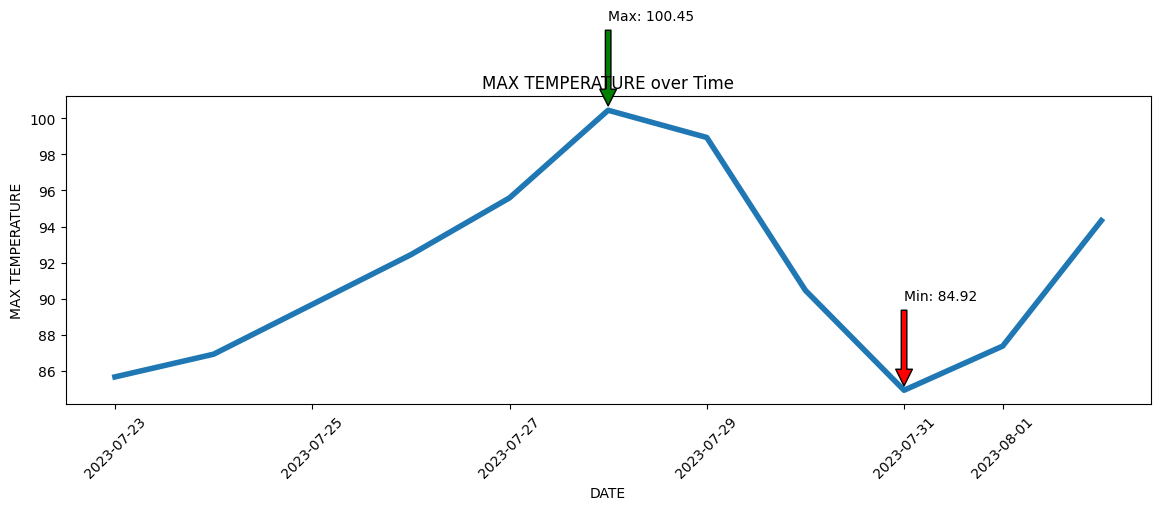

In [91]:
weather_sorted = weather_append.sort_values(by='DATE', ascending=False).head(10)
weather_sorted.set_index('DATE', inplace=True)

# Convert 'MAX TEMPERATURE' to numeric, coerce errors to NaN
weather_sorted['MAX TEMPERATURE'] = pd.to_numeric(weather_sorted['MAX TEMPERATURE'], errors='coerce')

plt.figure(figsize=(14, 4))
plt.plot(weather_sorted['MAX TEMPERATURE'], linewidth=4)

# Find min and max values
min_temp = weather_sorted['MAX TEMPERATURE'].min()
max_temp = weather_sorted['MAX TEMPERATURE'].max()

# Find the dates corresponding to the min and max temperatures
min_date = weather_sorted[weather_sorted['MAX TEMPERATURE'] == min_temp].index[0]
max_date = weather_sorted[weather_sorted['MAX TEMPERATURE'] == max_temp].index[0]

# Annotate the min and max points on the graph
plt.annotate(f'Min: {min_temp}', xy=(min_date, min_temp), xytext=(min_date, min_temp+5),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate(f'Max: {max_temp}', xy=(max_date, max_temp), xytext=(max_date, max_temp+5),
             arrowprops=dict(facecolor='green', shrink=0.05))

plt.xticks(rotation=45)
plt.title('MAX TEMPERATURE over Time')
plt.xlabel('DATE')
plt.ylabel('MAX TEMPERATURE')
plt.grid(False)
plt.show()


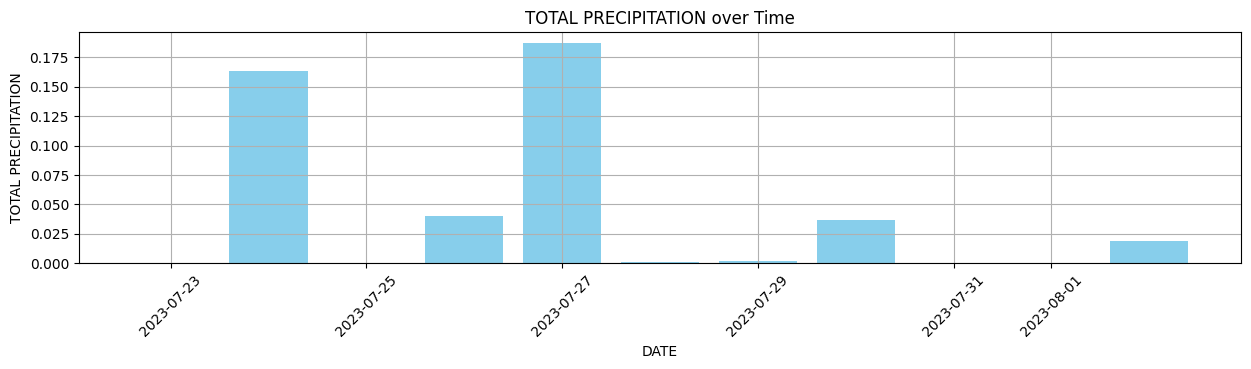

In [92]:
# Plot TOTAL PRECIPITATION
plt.figure(figsize=(15, 3))
plt.bar(weather_sorted.index, weather_sorted['TOTAL PRECIPITATION'], color='skyblue')
plt.xticks(rotation=45)
plt.title('TOTAL PRECIPITATION over Time')
plt.xlabel('DATE')
plt.ylabel('TOTAL PRECIPITATION')
plt.grid(True)
plt.show()

In [93]:
unique_trails = trail_df['trail'].unique().tolist()

# create an empty list to store the duplicated rows
new_rows = []

# loop through each row in the original DataFrame
for _, row in weather_append.iterrows():
    # loop through each unique string and create a new row with the string added
    for string in unique_trails:
        new_row = row.copy()
        new_row['DESCRIPTION'] = string
        new_rows.append(new_row)
weather_append.columns

Index(['DATE', 'MAX TEMPERATURE', 'AVG WIND', 'TOTAL PRECIPITATION'], dtype='object')

In [94]:
# create a new DataFrame with the duplicated rows
new_df = pd.DataFrame(new_rows)

# reset the index of the new DataFrame
new_df.reset_index(drop=True, inplace=True)
new_df.head()

,DATE,MAX TEMPERATURE,AVG WIND,TOTAL PRECIPITATION,DESCRIPTION
0,2023-07-24,86.92,16.11,0.163386,East Fork State Park
1,2023-07-24,86.92,16.11,0.163386,Premier Health Bike Park
2,2023-07-24,86.92,16.11,0.163386,Milford Trails
3,2023-07-24,86.92,16.11,0.163386,Tower Park
4,2023-07-24,86.92,16.11,0.163386,England Idlewild


In [95]:
# create a dictionary that maps the old column names to the new column names
column_names = {'DATE': 'date_clean', 'MAX TEMPERATURE': 'TMAX', 'AVG WIND': 'AWND', 'TOTAL PRECIPITATION': 'PRCP', 'DESCRIPTION': 'trail'}

# rename the columns using the rename() method with the column_names dictionary
new_df = new_df.rename(columns=column_names)
new_df.head(1)

,date_clean,TMAX,AWND,PRCP,trail
0,2023-07-24,86.92,16.11,0.163386,East Fork State Park


In [96]:
len(new_df)

14220

In [97]:
model_df['date_clean'] = pd.to_datetime(model_df['date_clean'])
model_df['date_clean'] = model_df['date_clean'].dt.date

# weather_data_main = pd.concat([model_df, new_df], axis=0)
weather_data_main = new_df.copy()
weather_data_main = weather_data_main.drop_duplicates(subset=['date_clean', 'trail'])
print(model_df['date_clean'].min())
print(model_df['date_clean'].max())
print(new_df['date_clean'].min())
print(new_df['date_clean'].max())

2020-01-01
2023-03-16
2020-01-01
2023-08-02


## QA NOTE: Stopping At March 16th, 2023 because that's when CORA history ends

In [98]:
weather_data_main.sort_values('date_clean', ascending = False).head(15)['date_clean'].unique()

array([datetime.date(2023, 8, 2), datetime.date(2023, 8, 1)], dtype=object)

### Check to see if we have necessary dates 

In [99]:
if weather_data_main['date_clean'].max() < new_df['date_clean'].min():
    print("WARNING missing weather data")
else:
    print("GOOD we have the proper data needed")

GOOD we have the proper data needed


# Feature Engineering

## Define Lookbacks (# of days for each feature)

In [100]:
# Create new columns 
for i in lookback_days_list:
    for col in ['PRCP', 'TMAX']:
        if col == 'PRCP':
            # Calculate the cumulative sum of 'PRCP' for the past X days
            weather_data_main[f'{col}_{i}d'] = weather_data_main[col].rolling(window=i).sum().shift(1)
        else:
            # Calculate the average of 'AWND' and 'TAVG' for the past X days
            weather_data_main[f'{col}_{i}d'] = weather_data_main[col].rolling(window=i).mean().shift(1)

# Replace missing values with 0
weather_data_main.fillna(0, inplace=True)

weather_data_main.head(1)

,date_clean,TMAX,AWND,PRCP,trail,PRCP_2d,TMAX_2d,PRCP_3d,TMAX_3d,PRCP_7d,TMAX_7d
0,2023-07-24,86.92,16.11,0.163386,East Fork State Park,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
# Filter to future dates

today = pd.Timestamp.today().normalize() # Get today's date
future_dates_mask = weather_data_main['date_clean'] >= today
weather_data_main_future = weather_data_main[future_dates_mask]


In [102]:
datetime_cols = model_df.select_dtypes(include=[np.datetime64, 'datetime', 'datetime64']).columns.tolist()
model_df['date_clean'] = model_df['date_clean'].astype('datetime64[ns]')
model_df['target'] = model_df['target'].astype('int64')
model_df['target'].value_counts()

1    8503
0    5549
Name: target, dtype: int64

# Write Out Data

In [103]:
model_df.to_csv('01_mtb_model_df_out.csv')

In [104]:
weather_data_main_future.to_csv('01_mtb_weather_data_main_future_out.csv')